In [1]:
import DrivAER as dv
import scanpy as sc
import anndata as ad
import pandas as pd
import random

sc.settings.verbosity = 1
sc.set_figure_params(vector_friendly=True,dpi=40,transparent=True)

C:\Users\lukas.simon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\lukas.simon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\lukas.simon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\lukas.s

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R  
library('splatter')

## Simulate data

In [4]:
%%R -o count
sim.groups <- splatSimulate(batchCells = 600,
                            seed=1,
                            nGenes = 1000,
                            group.prob = c(0.5, 0.5),
                            de.prob = 0.1,
                            mean.shape = 0.5,
                            method = "groups",
                            verbose = FALSE)
count <- as.data.frame(counts(sim.groups))

C:\Users\lukas.simon\AppData\Local\Continuum\anaconda3\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [5]:
%%R -o group
group <- colData(sim.groups)[,3]

In [6]:
%%R -o de
de <- rowData(sim.groups)[,5]

In [7]:
import numpy as np
count = np.array(count, dtype = 'int')
counts = count.T
counts = counts[np.where(np.sum(counts, 1) > 0)]

## Convert to anndata object

In [10]:
sim_groups = ad.AnnData(counts)
sim_groups.var_names = ['gene' + str(i) for i in range(0, counts.shape[1])]
sim_groups.obs['group'] = group
sim_groups.obs['group']= sim_groups.obs['group'].apply(str)
sim_groups.var['DE'] = de
sc.pp.filter_genes(sim_groups, min_counts=1)

In [8]:
def mix(n):
    df = sim_groups.var.copy()
    group_A = df[df['DE'] == 1].index.tolist()
    group_B = df[df['DE'] != 1].index.tolist()
    random.shuffle(group_A)
    chunk, group_A = group_A[:n], group_A[n:]
    group_B.extend(chunk)
    return pd.Series([group_A, group_B], index=['control', 'true'])

In [9]:
from DrivAER.dca_drivaer import *

In [11]:
import os, tempfile, shutil, random
import anndata
import numpy as np
import scanpy as sc
import scipy as sp

try:
    import tensorflow as tf
except ImportError:
    raise ImportError('DCA requires tensorflow. Please follow instructions'
                      ' at https://www.tensorflow.org/install/ to install'
                      ' it.')


#from dca.io import read_dataset
from dca.train import train
from dca.network import AE_types

def read_dataset(adata, transpose=False, test_split=False, copy=False):

    if isinstance(adata, sc.AnnData):
        if copy:
            adata = adata.copy()
    elif isinstance(adata, str):
        adata = sc.read(adata, first_column_names=True)
    else:
        raise NotImplementedError

    # check if observations are unnormalized using first 10
    X_subset = adata.X[:10]
    norm_error = 'Make sure that the dataset (adata.X) contains unnormalized count data.'
    if sp.sparse.issparse(X_subset):
        assert (X_subset.astype(int) != X_subset).nnz == 0, norm_error
    else:
        assert np.all(X_subset.astype(int) == X_subset), norm_error

    if transpose: adata = adata.transpose()

    if test_split:
        train_idx, test_idx = train_test_split(np.arange(adata.n_obs), test_size=0.1, random_state=42)
        spl = pd.Series(['train'] * adata.n_obs)
        spl.iloc[test_idx] = 'test'
        adata.obs['dca_split'] = spl.values
    else:
        adata.obs['dca_split'] = 'train'

        adata.obs['dca_split'] = adata.obs['dca_split'].astype('category')
        #print('dca: Successfully preprocessed {} genes and {} cells.'.format(adata.n_vars, adata.n_obs))
        return adata


def dca_drivaer(adata,
        mode='latent',
        ae_type='zinb-conddisp',
        normalize_per_cell=True,
        scale=True,
        log1p=True,
        hidden_size=(64, 32, 64), # network args
        hidden_dropout=0.,
        batchnorm=True,
        activation='relu',
        init='glorot_uniform',
        network_kwds={},
        epochs=300,               # training args
        reduce_lr=10,
        early_stop=15,
        batch_size=32,
        optimizer='rmsprop',
        learning_rate=None,
        random_state=0,
        threads=None,
        verbose=False,
        training_kwds={},
        return_model=False,
        return_info=False,
        copy=False
        ):
    """Deep count autoencoder(DCA) API.
    Fits a count autoencoder to the count data given in the anndata object
    in order to denoise the data and capture hidden representation of
    cells in low dimensions. Type of the autoencoder and return values are
    determined by the parameters.
    Parameters
    ----------
    adata : :class:`~scanpy.api.AnnData`
        An anndata file with `.raw` attribute representing raw counts.
    mode : `str`, optional. `denoise`(default), or `latent`.
        `denoise` overwrites `adata.X` with denoised expression values.
        In `latent` mode DCA adds `adata.obsm['X_dca']` to given adata
        object. This matrix represent latent representation of cells via DCA.
    ae_type : `str`, optional. `zinb-conddisp`(default), `zinb`, `nb-conddisp` or `nb`.
        Type of the autoencoder. Return values and the architecture is
        determined by the type e.g. `nb` does not provide dropout
        probabilities.
    normalize_per_cell : `bool`, optional. Default: `True`.
        If true, library size normalization is performed using
        the `sc.pp.normalize_per_cell` function in Scanpy and saved into adata
        object. Mean layer is re-introduces library size differences by
        scaling the mean value of each cell in the output layer. See the
        manuscript for more details.
    scale : `bool`, optional. Default: `True`.
        If true, the input of the autoencoder is centered using
        `sc.pp.scale` function of Scanpy. Note that the output is kept as raw
        counts as loss functions are designed for the count data.
    log1p : `bool`, optional. Default: `True`.
        If true, the input of the autoencoder is log transformed with a
        pseudocount of one using `sc.pp.log1p` function of Scanpy.
    hidden_size : `tuple` or `list`, optional. Default: (64, 32, 64).
        Width of hidden layers.
    hidden_dropout : `float`, `tuple` or `list`, optional. Default: 0.0.
        Probability of weight dropout in the autoencoder (per layer if list
        or tuple).
    batchnorm : `bool`, optional. Default: `True`.
        If true, batch normalization is performed.
    activation : `str`, optional. Default: `relu`.
        Activation function of hidden layers.
    init : `str`, optional. Default: `glorot_uniform`.
        Initialization method used to initialize weights.
    network_kwds : `dict`, optional.
        Additional keyword arguments for the autoencoder.
    epochs : `int`, optional. Default: 300.
        Number of total epochs in training.
    reduce_lr : `int`, optional. Default: 10.
        Reduces learning rate if validation loss does not improve in given number of epochs.
    early_stop : `int`, optional. Default: 15.
        Stops training if validation loss does not improve in given number of epochs.
    batch_size : `int`, optional. Default: 32.
        Number of samples in the batch used for SGD.
    learning_rate : `float`, optional. Default: None.
        Learning rate to use in the training.
    optimizer : `str`, optional. Default: "rmsprop".
        Type of optimization method used for training.
    random_state : `int`, optional. Default: 0.
        Seed for python, numpy and tensorflow.
    threads : `int` or None, optional. Default: None
        Number of threads to use in training. All cores are used by default.
    verbose : `bool`, optional. Default: `False`.
        If true, prints additional information about training and architecture.
    training_kwds : `dict`, optional.
        Additional keyword arguments for the training process.
    return_model : `bool`, optional. Default: `False`.
        If true, trained autoencoder object is returned. See "Returns".
    return_info : `bool`, optional. Default: `False`.
        If true, all additional parameters of DCA are stored in `adata.obsm` such as dropout
        probabilities (obsm['X_dca_dropout']) and estimated dispersion values
        (obsm['X_dca_dispersion']), in case that autoencoder is of type
        zinb or zinb-conddisp.
    copy : `bool`, optional. Default: `False`.
        If true, a copy of anndata is returned.
    Returns
    -------
    If `copy` is true and `return_model` is false, AnnData object is returned.
    In "denoise" mode, `adata.X` is overwritten with the denoised values. In "latent" mode, latent
    low dimensional representation of cells are stored in `adata.obsm['X_dca']` and `adata.X`
    is not modified. Note that these values are not corrected for library size effects.
    If `return_info` is true, all estimated distribution parameters are stored in AnnData such as:
    - `.obsm["X_dca_dropout"]` which is the mixture coefficient (pi) of the zero component
    in ZINB, i.e. dropout probability. (Only if ae_type is zinb or zinb-conddisp)
    - `.obsm["X_dca_dispersion"]` which is the dispersion parameter of NB.
    - `.uns["dca_loss_history"]` which stores the loss history of the training.
    Finally, the raw counts are stored as `.raw`.
    If `return_model` is given, trained model is returned. When both `copy` and `return_model`
    are true, a tuple of anndata and model is returned in that order.
    """

    assert isinstance(adata, anndata.AnnData), 'adata must be an AnnData instance'
    assert mode in ('denoise', 'latent'), '%s is not a valid mode.' % mode

    # set seed for reproducibility
    random.seed(random_state)
    np.random.seed(random_state)
    tf.set_random_seed(random_state)
    os.environ['PYTHONHASHSEED'] = '0'

    # this creates adata.raw with raw counts and copies adata if copy==True
    adata = read_dataset(adata,
                        transpose=False,
                        test_split=False,
                        copy=copy)
    # check for zero genes
    nonzero_genes, _ = sc.pp.filter_genes(adata.X, min_counts=1)
    assert nonzero_genes.all(), 'Please remove all-zero genes before using DCA.'

    def normalize_drivaer(adata, filter_min_counts=True, size_factors=True, normalize_input=True, logtrans_input=True):

        #genes = list(set(adata.var_names).intersection(set(genes)))
        if filter_min_counts:
            sc.pp.filter_genes(adata, min_counts=1)
            sc.pp.filter_cells(adata, min_counts=1)

        if size_factors or normalize_input or logtrans_input:
            adata.raw = adata.copy()
        else:
            adata.raw = adata

        if size_factors:
            sc.pp.normalize_per_cell(adata)
            if not "size_factors" in adata.obs_keys():
                adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
        else:
            adata.obs['size_factors'] = 1.0

        if logtrans_input:
            sc.pp.log1p(adata)

        if normalize_input:
            sc.pp.scale(adata)

        print('dca: Successfully preprocessed {} genes and {} cells.'.format(adata.n_vars, adata.n_obs))

        return adata

    adata = normalize_drivaer(adata,
                    filter_min_counts=False, # no filtering, keep cell and gene idxs same
                    size_factors=normalize_per_cell,
                    normalize_input=scale,
                    logtrans_input=log1p)

    network_kwds = {**network_kwds,
        'hidden_size': hidden_size,
        'hidden_dropout': hidden_dropout,
        'batchnorm': batchnorm,
        'activation': activation,
        'init': init
    }

    input_size = output_size = adata.n_vars
    net = AE_types[ae_type](input_size=input_size,
                            output_size=output_size,
                            **network_kwds)
    net.save()
    net.build()

    training_kwds = {**training_kwds,
        'epochs': epochs,
        'reduce_lr': reduce_lr,
        'early_stop': early_stop,
        'batch_size': batch_size,
        'optimizer': optimizer,
        'verbose': verbose,
        'threads': threads,
        'learning_rate': learning_rate
    }

    hist = train(adata[adata.obs.dca_split == 'train'], net, **training_kwds)
    res = net.predict(adata, mode)#, return_info, copy)
    adata = res if copy else adata

    if return_info:
        adata.uns['dca_loss_history'] = hist.history

    if return_model:
        return (adata, net) if copy else net
    else:
        return adata if copy else None


In [12]:
#from .dca_drivaer import dca_drivaer
import tensorflow
import scanpy as sc
import pandas as pd
import os
import anndata as ad
import numpy as np
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numbers
import scipy

def calc_relevance(count, pheno, tf_targets, min_targets,
                   ae_type="nb-conddisp", epochs=3, early_stop=3,
                   hidden_size=(8, 2, 8), verbose=False):

    sc.pp.filter_genes(count, min_counts=1)
    gene = count.var_names.tolist()
    # Restrict to expressed target genes
    tf_targets = tf_targets.map(lambda x: sorted(list(set(x) & set(gene))))
    # Restrict to TFs with at least min_targets genes
    targets =  tf_targets[tf_targets.map(lambda x: len(x) >= min_targets)]

    my_counter = [0]

    def fun_dca(v):
        my_counter[0] += 1
        print(f'{my_counter[0]} / {len(targets)}')

        tmp = count.copy()
        if(scipy.sparse.issparse(tmp.X)):
            tmp.X = tmp.X.toarray()
        tmp = ad.AnnData(tmp.X + 1)
        sc.pp.normalize_per_cell(tmp)
        size_factors = tmp.obs.n_counts/np.median(tmp.obs.n_counts)

        tmp = count[:,v].copy()
        if(scipy.sparse.issparse(tmp.X)):
            tmp.X = tmp.X.toarray()
        tmp = ad.AnnData(tmp.X + 1)
        tmp.obs["size_factors"]=size_factors

        ret = dca_drivaer(tmp, mode='latent',ae_type=ae_type,epochs=epochs,
        early_stop=early_stop,hidden_size=hidden_size,verbose=verbose,copy=True)
        return(ret["reduced"])

    embed = targets.map(fun_dca)

    # Random forest
    def fun_rfr(x):
        clf = RFR(n_estimators=500, oob_score = True)
        rf_fit = clf.fit(X = x, y= pheno)
        return rf_fit.oob_score_

    def fun_rfc(x):
        clf = RFC(n_estimators=500, oob_score = True)
        rf_fit = clf.fit(X = x, y= pd.factorize(pheno)[0])
        return rf_fit.oob_score_

    if isinstance(pheno[0], numbers.Number):
        rele_score = embed.map(fun_rfr)
    else:
        rele_score = embed.map(fun_rfc)

    return embed,rele_score


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numbers
import scanpy as sc
import rpy2.robjects as ro
import statsmodels.api as sm
from dca.api import dca

def rank_plot(result, save = False):
    score = pd.DataFrame(list(result[1].items()), columns=['Signature', 'Relevance Score'])
    score = score.sort_values('Relevance Score',ascending=False)
    new_df = score.head(5)
    new_df = new_df.append(score.tail(5))
    plt.figure(figsize=(10,10))
    ax = sns.barplot(x="Relevance Score", y="Signature", data=new_df, palette=sns.color_palette("Blues_r",10))
    plt.xticks(rotation='horizontal',fontsize=20)
    plt.yticks(fontsize=26)
    plt.xlabel('Relevance Score', fontsize=22)
    ax.grid(b=True, which='major', color='#d3d3d3', linewidth=0.5)
    fig = plt.gcf()
    plt.show()
    if save:
        fig.savefig(path + '/rank.svg', bbox_inches='tight')
    top_TF = score.head(n=5)['Signature'].tolist()
    print("Top_TF",":",top_TF)
    worse_TF = score.tail(n=5)['Signature'].tolist()
    print("Worse_TF",":",worse_TF)

def embedding_plot(result, tf_name, pheno, save = False):
    em = pd.DataFrame(result[0][tf_name],columns=['dca1','dca2'])
    plt.figure(figsize=(10, 8))

    if isinstance(pheno[0], numbers.Number):
        plt.scatter(em.dca1, em.dca2,c = pheno)
        cbar = plt.colorbar()
        cbar.set_label("pseudotime", labelpad=+1)
    else:
        em['group'] = pheno.values
        em = em.sample(frac=1)
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x='dca1', y='dca2', hue="group", data=em, s=50)
    plt.title(tf_name, fontsize=30)
    plt.xlabel("dca1", fontsize=30)
    plt.ylabel("dca2", fontsize=30)
    fig = plt.gcf()
    plt.show()
    if save:
        fig.savefig(path + tf_name + '.svg', bbox_inches='tight')

def gene_plot(result,tf_name,gene,count,pheno,save = False):
    em = pd.DataFrame(result[0][tf_name],columns=['dca1','dca2'])
    plt.figure(figsize=(10,8))
    if isinstance(pheno[0], numbers.Number):
        sc.pp.scale(count)
        expr = count[:,gene].X
        expr[expr > 2] = 2
        plt.scatter(em['dca1'], em['dca2'],c = expr)
        cbar = plt.colorbar()
        cbar.set_label("expression", labelpad=+1)
    else:
        em = em.set_index(count.obs.index)
        em['Value'] = pd.DataFrame(count[:,gene].X).values
        plt.figure(figsize=(10,8))
        cmap = sns.cubehelix_palette(dark=.2, light=0.9, as_cmap=True)
        sns.scatterplot(x='dca1', y='dca2', hue="Value",hue_norm=(-2,2),data=em,s=30,palette=cmap)
    plt.title(gene,fontsize=30)
    plt.xlabel("dca1",fontsize=30)
    plt.ylabel("dca2",fontsize=30)
    fig = plt.gcf()
    plt.show()
    if save:
        fig.savefig(path + gene + '.svg', bbox_inches='tight')


## Run DrivAER

### Define function to generate simulated gene sets

In [16]:
def generate_simulated_geneset(fraction = 0.9):
    df = sim_groups.var.copy()
    genes_nonde = df[df['DE'] == 1].index.tolist()
    genes_de = df[df['DE'] != 1].index.tolist()
    geneset = np.random.choice(np.array(genes_de), round(len(genes_de) * fraction), replace = False).tolist()
    random = np.random.choice(np.array(genes_nonde), round(len(genes_de) * (1 - fraction)), replace = False).tolist()
    geneset += random
    random = np.random.choice(np.array(genes_nonde), len(genes_de), replace = False).tolist()
    return pd.Series([random, geneset], index = ['control', 'true'])

In [17]:
accs = {}
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    random_list = []
    true_list = []
    for x in range(0,5):
        res = calc_relevance(count=sim_groups, pheno = sim_groups.obs['group'], tf_targets = generate_simulated_geneset(i), min_targets=1)
        random_list.append(res[1][0])
        true_list.append(res[1][1])
    accs.update({'random' + str(i): random_list})
    accs.update({'true' + str(i): true_list})

1 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Instructions for updating:
Colocations handled automatically by placer.


2020-04-28 08:10:49,124 [WARNING] From C:\Users\lukas.simon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


2020-04-28 08:10:49,741 [WARNING] From C:\Users\lukas.simon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Calculating low dimensional representations...
Calculating reconstructions...
2 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Calculating low dimensional representations...
Calculating reconstructions...
1 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Calculating low dimensional representations...
Calculating reconstructions...
2 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Calculating low dimensional representations...
Calculating reconstructions...
1 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Calculating low dimensional representations...
Calculating reconstructions...
2 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Calculating low dimensional representations...
Calculating reconstructions...
1 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Calculating low dimensional representations...
Calculating reconstructions...
2 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Calculating low dime

Calculating reconstructions...
2 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Calculating low dimensional representations...
Calculating reconstructions...
1 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Calculating low dimensional representations...
Calculating reconstructions...
2 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Calculating low dimensional representations...
Calculating reconstructions...
1 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Calculating low dimensional representations...
Calculating reconstructions...
2 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Calculating low dimensional representations...
Calculating reconstructions...
1 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Calculating low dimensional representations...
Calculating reconstructions...
2 / 2
dca: Successfully preprocessed 102 genes and 600 cells.
Calculating low dimensional representations...
Calculating reconstr

## Plot relevance scores

In [18]:
df = pd.DataFrame(accs)

C:\Users\lukas.simon\AppData\Local\Continuum\anaconda3\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


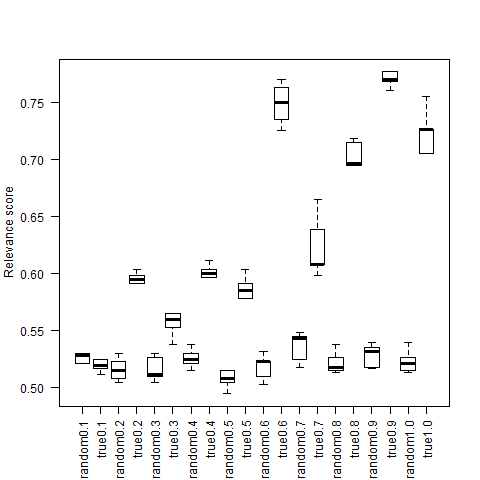

In [19]:
%%R -i df -o pvals

boxplot(df, las = 2, ylab = 'Relevance score', outline = F)
pvals <- c(t.test(df[,1], df[,2])$p.value, 
              t.test(df[,1], df[,4])$p.value,
              t.test(df[,1], df[,6])$p.value,
              t.test(df[,1], df[,8])$p.value,
              t.test(df[,1], df[,10])$p.value)

In [20]:
pvals

0.802271,0.000045,0.020970,0.000362,0.000086


In [35]:
def calc_relevance_pca(adata, pheno, tf_targets, min_targets):

    gene = adata.var_names.tolist()
    # Restrict to expressed target genes
    tf_targets = tf_targets.map(lambda x: sorted(list(set(x) & set(gene))))
    # Restrict to TFs with at least min_targets genes
    targets =  tf_targets[tf_targets.map(lambda x: len(x) >= min_targets)]

    my_counter = [0]

    def fun_dca(v):
        my_counter[0] += 1
        #print(f'{my_counter[0]} / {len(targets)}')

        tmp = adata[:,v].copy()
        sc.pp.pca(tmp, n_comps= 2)
        
        ret = tmp.obsm['X_pca'][:,0:1]
        return(ret)

    embed = targets.map(fun_dca)

    # Random forest
    def fun_rfr(x):
        clf = RFR(n_estimators=500, oob_score = True)
        rf_fit = clf.fit(X = x, y= pheno)
        return rf_fit.oob_score_

    def fun_rfc(x):
        clf = RFC(n_estimators=500, oob_score = True)
        rf_fit = clf.fit(X = x, y= pd.factorize(pheno)[0])
        return rf_fit.oob_score_

    if isinstance(pheno[0], numbers.Number):
        rele_score = embed.map(fun_rfr)
    else:
        rele_score = embed.map(fun_rfc)

    return embed,rele_score

def calc_relevance_umap(adata, pheno, tf_targets, min_targets):

    gene = adata.var_names.tolist()
    # Restrict to expressed target genes
    tf_targets = tf_targets.map(lambda x: sorted(list(set(x) & set(gene))))
    # Restrict to TFs with at least min_targets genes
    targets =  tf_targets[tf_targets.map(lambda x: len(x) >= min_targets)]

    my_counter = [0]

    def fun_dca(v):
        my_counter[0] += 1
        #print(f'{my_counter[0]} / {len(targets)}')

        tmp = adata[:,v].copy()
        sc.pp.pca(tmp)
        sc.pp.neighbors(tmp)
        sc.tl.umap(tmp)
        
        ret = tmp.obsm['X_umap']
        return(ret)

    embed = targets.map(fun_dca)

    # Random forest
    def fun_rfr(x):
        clf = RFR(n_estimators=500, oob_score = True)
        rf_fit = clf.fit(X = x, y= pheno)
        return rf_fit.oob_score_

    def fun_rfc(x):
        clf = RFC(n_estimators=500, oob_score = True)
        rf_fit = clf.fit(X = x, y= pd.factorize(pheno)[0])
        return rf_fit.oob_score_

    if isinstance(pheno[0], numbers.Number):
        rele_score = embed.map(fun_rfr)
    else:
        rele_score = embed.map(fun_rfc)

    return embed,rele_score

def calc_relevance_tsne(adata, pheno, tf_targets, min_targets):

    gene = adata.var_names.tolist()
    # Restrict to expressed target genes
    tf_targets = tf_targets.map(lambda x: sorted(list(set(x) & set(gene))))
    # Restrict to TFs with at least min_targets genes
    targets =  tf_targets[tf_targets.map(lambda x: len(x) >= min_targets)]

    my_counter = [0]

    def fun_dca(v):
        my_counter[0] += 1
        #print(f'{my_counter[0]} / {len(targets)}')

        tmp = adata[:,v].copy()
        sc.pp.pca(tmp)
        sc.pp.neighbors(tmp)
        sc.tl.tsne(tmp)
        
        ret = tmp.obsm['X_tsne']
        return(ret)

    embed = targets.map(fun_dca)

    # Random forest
    def fun_rfr(x):
        clf = RFR(n_estimators=500, oob_score = True)
        rf_fit = clf.fit(X = x, y= pheno)
        return rf_fit.oob_score_

    def fun_rfc(x):
        clf = RFC(n_estimators=500, oob_score = True)
        rf_fit = clf.fit(X = x, y= pd.factorize(pheno)[0])
        return rf_fit.oob_score_

    if isinstance(pheno[0], numbers.Number):
        rele_score = embed.map(fun_rfr)
    else:
        rele_score = embed.map(fun_rfc)

    return embed,rele_score

In [25]:
adata = sc.pp.normalize_per_cell(sim_groups, copy=True)
sc.pp.scale(adata)

In [36]:
accs_pca = {}
for i in [0.2, 0.4, 0.6, 0.8, 1.0]:
    random_list = []
    true_list = []
    for x in range(0,2):
        res = calc_relevance_pca(adata=adata, pheno = sim_groups.obs['group'], tf_targets = generate_simulated_geneset(i), min_targets=1)
        random_list.append(res[1][0])
        true_list.append(res[1][1])
    accs_pca.update({'random' + str(i): random_list})
    accs_pca.update({'true' + str(i): true_list})

1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2


In [38]:
accs_pca

{'random0.2': [0.96, 0.815],
 'true0.2': [0.99, 1.0],
 'random0.4': [0.7866666666666666, 0.7216666666666667],
 'true0.4': [0.9966666666666667, 1.0],
 'random0.6': [0.81, 0.815],
 'true0.6': [1.0, 1.0],
 'random0.8': [0.6316666666666667, 0.9566666666666667],
 'true0.8': [1.0, 1.0],
 'random1.0': [0.87, 0.715],
 'true1.0': [1.0, 1.0]}

In [ ]:
accs_umap = {}
for i in [0.2, 0.4, 0.6, 0.8, 1.0]:
    random_list = []
    true_list = []
    for x in range(0,2):
        res = calc_relevance_umap(adata=adata, pheno = sim_groups.obs['group'], tf_targets = generate_simulated_geneset(i), min_targets=1)
        random_list.append(res[1][0])
        true_list.append(res[1][1])
    accs_pca.update({'random' + str(i): random_list})
    accs_pca.update({'true' + str(i): true_list})

1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
2 / 2
1 / 2
